# Understanding the problem

The task consists on continuing the work done before during previous module, with the addition of playing with non-linear models to improve the performance. Moreover, we're again asked to build a MVP within a API developed by our engineering team, so it must have a fit code and a inference code which later on we will define separatedly.

We will take all the decision and filters as granted from previous module, despite not being the best nor most accurate, such as:
- Baseline might be a linear model or global_popularity
- Feature selection might be more extensive
- Splittig sets using cumulative data instead of hard coded %'s. Even apply cross-validation addressing data leakages (ordered_before, global_popularity also if we are very nitpicky)

So we will copy all previous code and start from there applyin non-linear models, hence our baseline in this module would be the best model choosen in previous one (ridge regularisation with C=1e-5)

## Import libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import timedelta, datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import pickle
import os

# Functions used in previous MVP

In [16]:
def assess_NA(data: pd.DataFrame):
    """
    Returns a pd.DataFrame denoting the total number of NA
    values and the percentage of NA values in each column.
    """
    # pd.Datadenoting features and the sum of their null values
    nulls = data.isnull().sum().reset_index().rename(columns={0: "count"})
    nulls["percent"] = nulls["count"] * 100 / len(data)

    return nulls


def read_data(file_path: str) -> pd.DataFrame:
    """
    Read and validate data from a CSV file.
    Parameters: file_path (str)
    Returns: pd.DataFrame
    """
    try:
        data = pd.read_csv(file_path, index_col=False)

        if data is not None and not data.empty:
            logging.info("Data loaded successfully.")

            # Info about its shape and nulls
            rows, cols = data.shape
            logging.info(f"Data shape: {rows} rows x {cols} columns")

            null_assessment = assess_NA(data)
            logging.info(
                "Assessment of NA values:\n" + null_assessment.to_string(index=False)
            )

            # Show data sample
            print(data.head(5))

            return data
        else:
            logging.error("Error: The loaded data is empty or None")
            return

    except FileNotFoundError as e:
        logging.error(f"Error: The CSV file is empty. Details: {e}")
    except pd.errors.EmptyDataError as e:
        logging.error(
            f"Error: An unexpected error occurred while loading the data. Details {e}"
        )


def preprocess_data(
    data: pd.DataFrame, remove_if_all_na: bool = False, num_items: int = 5
) -> pd.DataFrame:
    """
    Preprocess data by removing rows with
    filter orders with at least 5 items

    Parameters:
    - data (pd.DataFrame)
    - remove_all_na_rows (bool): If True, remove rows where at least
    1 value is missing. If False, remove rows where all values are missing.

    Returns:
    - pd.DataFrame. The preprocessed dataset
    """
    try:
        initial_length = len(data)
        if remove_if_all_na:  # remove if everything is NA
            data = data.dropna(how="all")
        else:
            data = data.dropna()
        dropped_length = len(data)

        # Filter orders with >= 5 items
        num_items_ordered = data.groupby("order_id")["outcome"].transform("sum")
        processed_data = data[num_items_ordered >= num_items]

        logging.info(f"Length initial data: {len(data)}")
        logging.info(f"Rows dropped with NA's: {initial_length - dropped_length}")
        logging.info(f"Length filtered data: {len(processed_data)}\n")

        return processed_data

    except FileNotFoundError as e:
        logging.error(f"Error: File not found. Details {e}")
        return


def split_sets(df: pd.DataFrame, label: str) -> (pd.DataFrame, pd.Series):
    """
    Return a df with X set (features) and a series y set (outcome)

    Parameters:
    - df: pd.DataFrame

    Returns:
    - X: pd.DataFrame (features only)
    - y: pd.Series (label to predict)
    """
    X = df.drop(columns=label)
    y = df[label]

    return X, y


def temporal_data_split(
    data: pd.DataFrame,
    validation_days: int = 10,
    test_days: int = 10,
    label: str = "outcome",
):
    """
    Perform the temporal data splitting into train, validation, and test set.

    Parameters:
    - data : pd.DataFrame
    - validation_days (int): Number of days for the validation set (default: 10).
    - test_days (int): Number of days for the test set (default: 10).
    - label (str): Name of the outcome variable (default: 'outcome').

    Returns:
    - pd.DataFrame: Training set features.
    - pd.Series: Training set outcome.
    - pd.DataFrame: Validation set features.
    - pd.Series: Validation set outcome.
    - pd.DataFrame: Test set features.
    - pd.Series: Test set outcome.
    """
    try:
        # Check order_date is a datetime and then we group the orders
        try:
            data["order_date"] = pd.to_datetime(data["order_date"]).dt.date
        except KeyError as ke:
            logging.error(f"Key Error: {str(ke)}")
            return
        daily_orders = data.groupby("order_date").order_id.nunique()

        start_date = daily_orders.index.min()
        end_date = daily_orders.index.max()
        logging.info(f"Date from: {start_date}")
        logging.info(f"Date to: {end_date}")

        # Based on the number of days, we get the train days
        num_days = len(daily_orders)
        train_days = num_days - test_days - validation_days

        # Train
        train_start = daily_orders.index.min()
        train_end = train_start + timedelta(days=train_days)

        # Validation (no need to define test)
        validation_end = train_end + timedelta(days=validation_days)

        # Defined the cols finally used for model
        cols = numerical + binary + predicted

        train = data[data.order_date <= train_end][cols]
        val = data[(data.order_date > train_end) & (data.order_date <= validation_end)][
            cols
        ]
        test = data[data.order_date > validation_end][cols]

        logging.info(f"Train set ratio: {len(train) / len(data):.2%}")
        logging.info(f"Validation set ratio: {len(val) / len(data):.2%}")
        logging.info(f"Test set ratio: {len(test) / len(data):.2%}")

        X_train, y_train = split_sets(train, label)
        X_val, y_val = split_sets(val, label)
        X_test, y_test = split_sets(test, label)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # not the best practice to catch all exceptio
    except KeyError as ke:
        logging.error(f"Key Error: {str(ke)}")
        return


def generate_evaluation_curves(
    model_name: str, C: float, y_pred, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for a binary classification model
    and save them in a single figure.

    Parameters:
    - model_name (str): Name of the model for labeling the curves.
    - y_pred (array-like): Predicted probabilities or scores.
    - y_test (array-like): True labels.
    - save_curves_path (str, optional): Directory to save the generated figure.
    If None, the figure will not be saved.

    Returns:
    - None
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_name} (C = {C:.2e})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(
        recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_name} (C = {C:.2e})"
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_{model_name}_C={C}_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()


def train_evaluate_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    save_model_path: str = None,
    save_curves_path: str = None,
):
    """
    Train, evaluate, and save a logistic regression model with hyperparameter
    tuning for regularisation. Additionally, plot the curves for ROC and PR.

    Parameters:
    - X_train (pd.DataFrame): Training set features.
    - y_train (pd.Series): Training set outcome.
    - X_val (pd.DataFrame): Validation set features.
    - y_val (pd.Series): Validation set outcome.
    - save_model_path (str, optional): Path to save the trained model.
    - save_curves_path (str, optional): Directory to save the generated figure.
    Returns:
    - None
    """
    # Define parameter grid for C values
    # We know in advance that strong params works better
    param_grid = {"lr__C": np.logspace(-8, -2, num=9)}

    # Create the pipeline
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l2", solver="liblinear")),
        ]
    )
    try:
        # Search for the best C hyperparameter
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Get the best model and best parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Return probabilities for plotting the curves
        y_pred = best_model.predict_proba(X_val)[:, 1]

        # Print and save the evaluation curves (ROC and PR)
        generate_evaluation_curves(
            "LogisticRegression", best_params["lr__C"], y_pred, y_val, save_curves_path
        )

        # Save the best model
        if save_model_path:
            lr_C = best_params["lr__C"]
            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            model_filename = f"LogisticRegression_{lr_C}_{timestamp}.joblib"
            model_path = os.path.join(save_model_path, model_filename)
            joblib.dump(best_model, model_path)

            logging.info(f"Model {model_filename} saved  successfully!")
        else:
            logging.info("Model run but not saved")


    except ValueError as e:
        logging.error(f"ValueError: {str(e)}")

    except pickle.PickleError as e:
        logging.error(f"Error during model save: {str(e)}")

In [17]:
file_path = '/home/dan1dr/data/feature_frame.csv'
pd.set_option('display.max_columns', None)

logging.basicConfig(
    level=logging.INFO,  # Set logging level (others: DEBUG, WARNING, ERROR, etc.)
    format="%(levelname)s - %(message)s",  # Define the log message format
)

# We will remeber the classification we did in previous notebook:

predicted = ['outcome']
information = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
numerical = ['user_order_seq', 'normalised_price', 'discount_pct', 'global_popularity',
            'count_adults', 'count_children', 'count_babies', 'count_pets', 
            'people_ex_baby', 'days_since_purchase_variant_id', 
            'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
            'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type']

categorical = ['product_type', 'vendor']
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

INFO - Data loaded successfully.
INFO - Data shape: 2880549 rows x 27 columns
INFO - Assessment of NA values:
                           index  count  percent
                      variant_id      0      0.0
                    product_type      0      0.0
                        order_id      0      0.0
                         user_id      0      0.0
                      created_at      0      0.0
                      order_date      0      0.0
                  user_order_seq      0      0.0
                         outcome      0      0.0
                  ordered_before      0      0.0
                abandoned_before      0      0.0
                  active_snoozed      0      0.0
                  set_as_regular      0      0.0
                normalised_price      0      0.0
                    discount_pct      0      0.0
                          vendor      0      0.0
               global_popularity      0      0.0
                    count_adults      0      0.0
        

       variant_id     product_type       order_id        user_id  \
0  33826472919172  ricepastapulses  2807985930372  3482464092292   
1  33826472919172  ricepastapulses  2808027644036  3466586718340   
2  33826472919172  ricepastapulses  2808099078276  3481384026244   
3  33826472919172  ricepastapulses  2808393957508  3291363377284   
4  33826472919172  ricepastapulses  2808429314180  3537167515780   

            created_at           order_date  user_order_seq  outcome  \
0  2020-10-05 16:46:19  2020-10-05 00:00:00               3      0.0   
1  2020-10-05 17:59:51  2020-10-05 00:00:00               2      0.0   
2  2020-10-05 20:08:53  2020-10-05 00:00:00               4      0.0   
3  2020-10-06 08:57:59  2020-10-06 00:00:00               2      0.0   
4  2020-10-06 10:37:05  2020-10-06 00:00:00               3      0.0   

   ordered_before  abandoned_before  active_snoozed  set_as_regular  \
0             0.0               0.0             0.0             0.0   
1             0.

INFO - Length initial data: 2880549
INFO - Rows dropped with NA's: 0
INFO - Length filtered data: 2163953

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


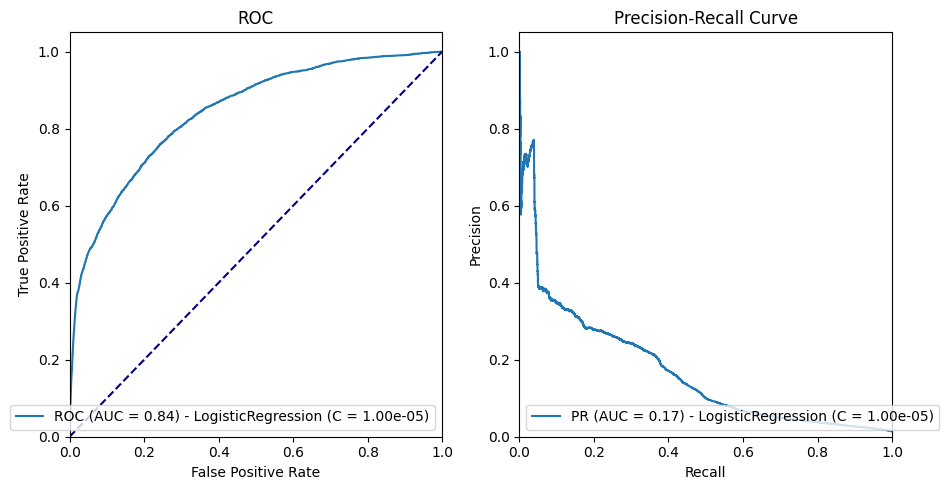

INFO - Model run but not saved


In [18]:
data_loaded = read_data(file_path)
data_processed = preprocess_data(data_loaded)
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed)
train_evaluate_model(X_train, y_train, X_val, y_val)

# Non-linear models

We will apply different models and compare against previous results, in the following order:
- Decision Trees
- Random Forests
- Gradient Bosting Trees

In that sense, let's modify the generate_evaluation_curves to plot multiple funcs at the same time, in order to compare visually the performance of each model vs. baseline.

In [29]:
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


## Decision Tree

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from datetime import datetime
import os

def generate_evaluation_curves_multi(
    model_names: list, y_preds: list, y_test, save_curves_path: str = None
):
    """
    Generate ROC and Precision-Recall curves for multiple binary classification models
    and display them in a single figure.
    """

    # Create a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    plt.figure(figsize=(10, 5))

    # Plot for each model
    for model_name, y_pred in zip(model_names, y_preds):

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f}) - {model_name}")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        pr_auc = auc(recall, precision)

        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.2f}) - {model_name}")

    # ROC Curve settings
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend(loc="lower right", prop={'size': 6})
    
    # Precision-Recall Curve settings
    plt.subplot(1, 2, 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right", prop={'size':6})

    plt.tight_layout()

    if save_curves_path:
        # Define the filename with a timestamp
        figure_filename = f"Evaluation_Curves_Multiple_Models_{timestamp}.png"
        figure_path = os.path.join(save_curves_path, figure_filename)

        plt.savefig(figure_path)

    plt.show()

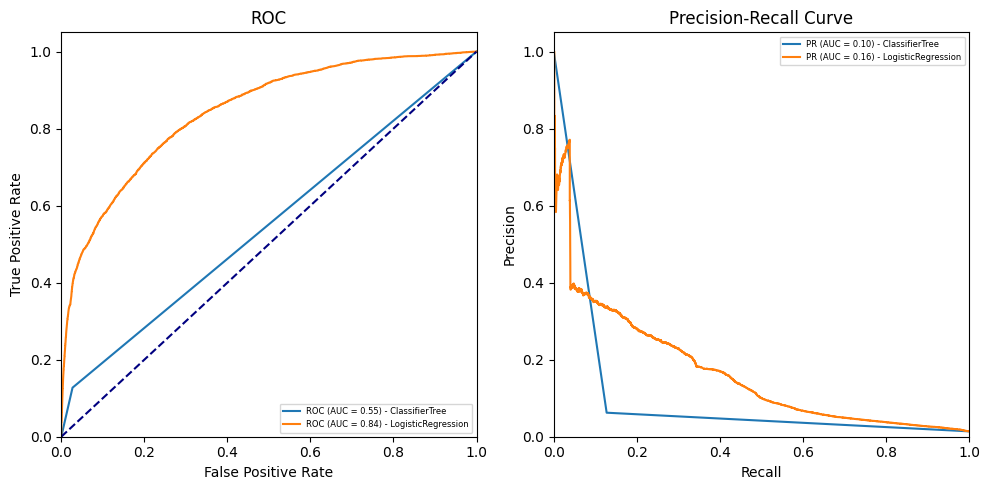

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Train regression tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_val)

# Train logistic regression
lr = LogisticRegression(penalty="l2", C=1e-5, solver="liblinear")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_val)[:, 1]

generate_evaluation_curves_multi(
    model_names=["ClassifierTree", "LogisticRegression"],
    y_preds=[y_pred_tree, y_pred_lr],
    y_test= y_val
)


Obviously, a single decision tree will hardly beat it. So we will try using random forests with different params of n_trees. As as curiosity, if we take a look at the plot for LR with same parameters as trained before, the AUC for PR is 0.16 vs 0.17 before (C, solver and  regularisation remains equal). I think this might happen as model regularisation can still have some randomness in model weights, hence getting different results.

## Random Forests

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression
lr = LogisticRegression(penalty="l2", C=1e-5, solver="liblinear")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_val)[:, 1]

# Train RandomForestClassifier for various n_trees
trained_models = []
y_preds_rf = []

n_trees_values = [5, 20, 50, 100, 250]
for n_trees in n_trees_values:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    y_preds_rf.append(rf.predict_proba(X_val)[:, 1])

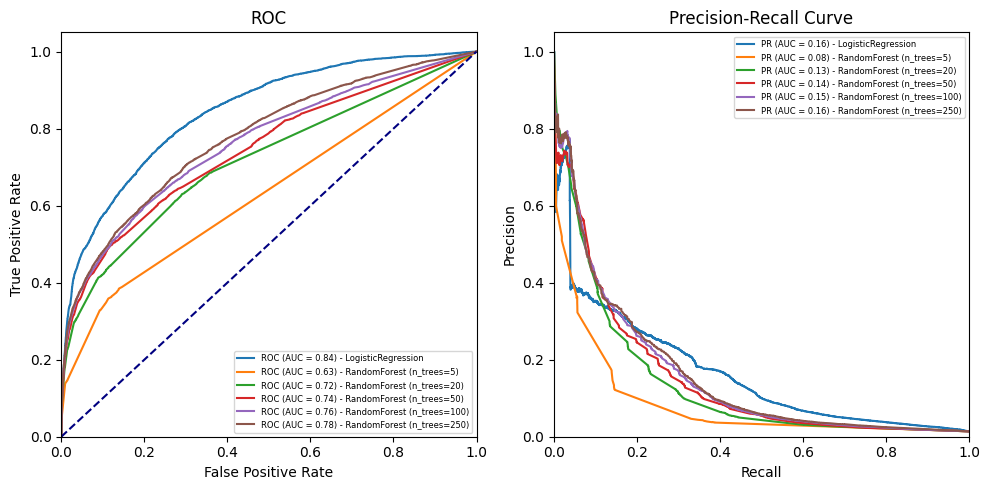

In [38]:
model_names = ["LogisticRegression"] + [f"RandomForest (n_trees={n})" for n in n_trees_values]
y_preds = [y_pred_lr] + y_preds_rf

generate_evaluation_curves_multi(model_names, y_preds, y_val)

For ROC we see no improvement, whereas higher number of trees works better than just a few. This model didn't improve our baseline defined by the linear model in blue.

In Precision-Recall, we obtain similar AUC for 200 trees, with better results for RandomForest between 0-15% recall, and performing worse than logistic regression beyond 20% recall (we see blue and brown lines intersecting at that point). This would be interesting if we knew in advance the exact point we would like to be in, which we know more or less but will need to make more adjustments. 

As a result, no model has yet defeated our beatiful logistic regression. It is also worth to mention that training for this n_trees took around 20min, while lr run x10 faster - in case scalability and deployment plays an important role.

In [40]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    """
    Plot the feature importances of a tree-based model.

    Parameters:
    - model: Trained tree-based model (like RandomForest or DecisionTree).
    - feature_names: List of feature names.
    - title: Title of the plot.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.show()


In [53]:
X_train, y_train, X_val, y_val, X_test, y_test = temporal_data_split(data_processed)
feature_names = X_train.columns

INFO - Date from: 2020-10-05
INFO - Date to: 2021-03-03
INFO - Train set ratio: 73.44%
INFO - Validation set ratio: 13.32%
INFO - Test set ratio: 13.24%


In [55]:
# Train RandomForestClassifier for various n_trees and store them
n_trees_values = [5, 100]
rf_models = []  # List to store trained models

for n_trees in n_trees_values:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    rf_models.append(rf)

# We use this here because X_train was standardized (not able to run X_train.columns)
feature_names = data_processed[numerical+binary].columns

# Loop through each Random Forest model and plot its feature importance
for n_trees, rf_model in zip(n_trees_values, rf_models):
    plot_feature_importance(rf_model, feature_names, title=f"Random Forest (n_trees={n_trees}) Feature Importance")


## Gradient Boosting Trees

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

# Let's be conservative for reducing total time
n_trees_values = [5, 100, 250]
max_depth_values = [1, 3, 5]

trained_gbt_models = []
y_preds_gbt = []
gbt_model_names = []


for n_trees in n_trees_values:
    for depth in max_depth_values:
        gbt = GradientBoostingClassifier(
            n_estimators=n_trees,
            max_depth=depth
            )
        gbt.fit(X_train, y_train)

        trained_gbt_models.append(gbt)
        y_preds_gbt.append(gbt.predict_proba(X_val)[:, 1])
        gbt_model_names.append(f"GBT (n_trees={n_trees}, depth={max_depth})")

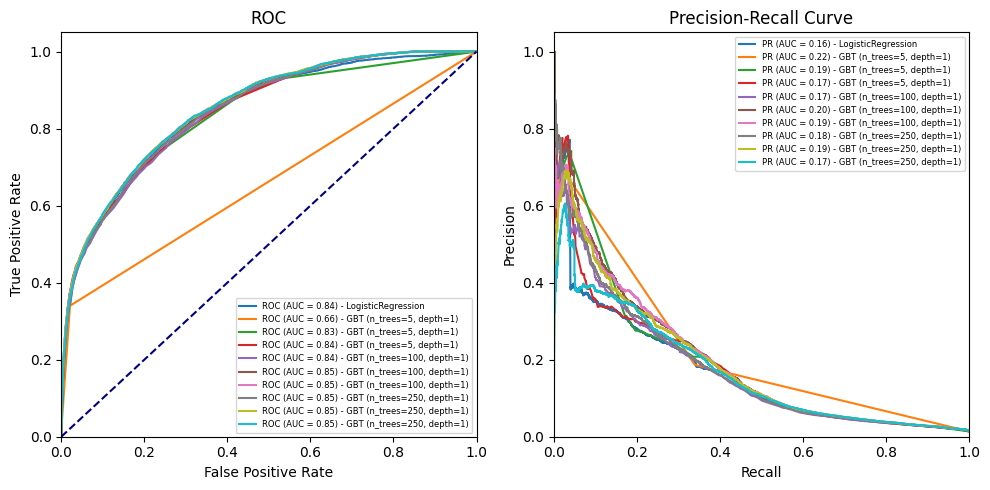

In [59]:
lr_model_name = ["LogisticRegression"]
rf_model_names = [f"RandomForest (n_trees={n})" for n in n_trees_values]

all_model_names = lr_model_name  + gbt_model_names
all_y_preds = [y_pred_lr]  + y_preds_gbt

# Now use the generate_evaluation_curves_multi function to plot:
generate_evaluation_curves_multi(
    model_names=all_model_names,
    y_preds=all_y_preds,
    y_test=y_val
)

BGT with n_trees = 100 and depth = 3 seems to be our best model (brown line, legend is wrong for depth values) yet very similar to LR.